# Assignment 2 - part b

In [141]:
from networkx.readwrite import json_graph
import json
import networkx as nx
import pandas as pd
import numpy as np

In [142]:
# Load super network
with open(f"supernetwork.json", "r") as infile:
    json_data = json.load(infile)
    G_superhero = json_graph.adjacency_graph(json_data)

In [143]:
# Get the largest component
superhero_subgraphs = [G_superhero.subgraph(
    c).copy() for c in nx.weakly_connected_components(G_superhero)]
GC_superhero = max(superhero_subgraphs, key=len)

In [144]:
# Create the undirected graph
GC_super_un = GC_superhero.to_undirected()

## Communities

### Task:  Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

In [145]:
# Build a strictly marvel based network..
marvel_nodes = (node for node, data in GC_super_un.nodes(data=True) if data.get("universe") == "marvel")
G_marvel_un = GC_super_un.subgraph(marvel_nodes)

In [146]:
import community

# Identify communities in the Marvel universe using the Louvian algorithm
partition_marvel = community.best_partition(G_marvel_un)

### Task: Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.

100%|██████████| 500/500 [00:10<00:00, 47.59it/s]


BarnesHut Approximation  took  6.36  seconds
Repulsion forces  took  3.80  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.13  seconds


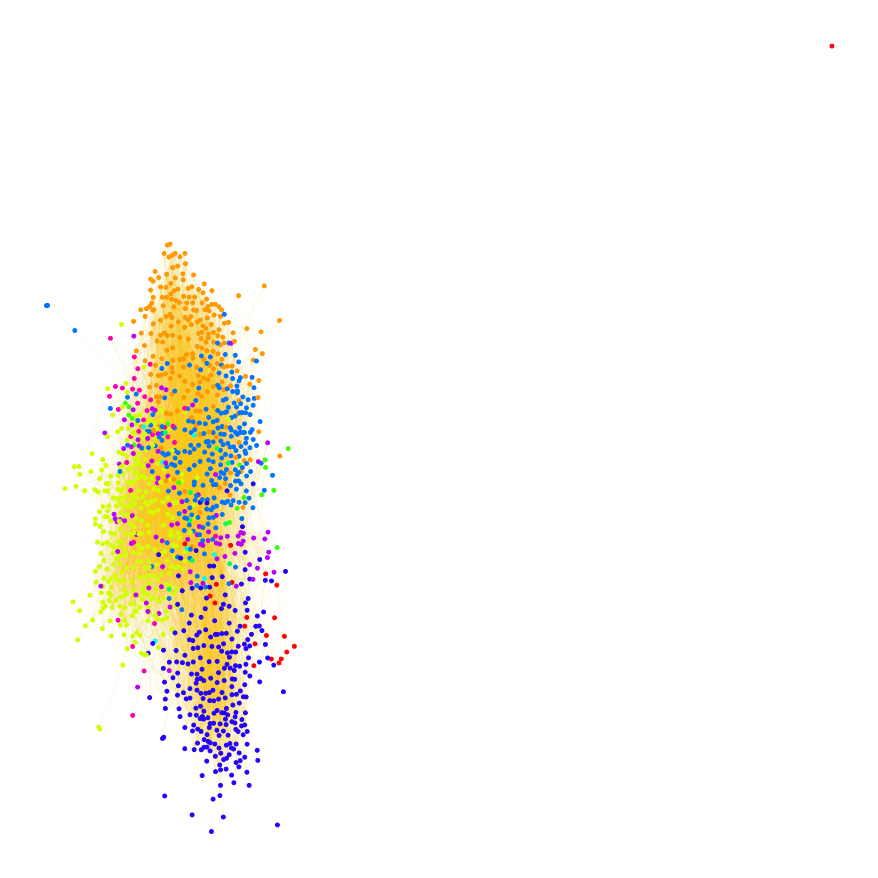

In [147]:
from fa2 import ForceAtlas2
import matplotlib.cm as cm
import matplotlib.pyplot as plt

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_marvel_un, pos=None, iterations=500)

plt.figure(figsize=(12, 12))
# color the nodes according to their partition
cmap = cm.get_cmap('hsv', max(partition_marvel.values()) + 1)
nx.draw(G_marvel_un, pos=positions, with_labels=False, node_size=15, width=0.05, 
        cmap=cmap, node_color=list(partition_marvel.values()), edge_color='#f9c80e')
plt.show()

### Write a paragraph about your work to identify the communities. The paragraph should include

* Information about the algorithm you used to find communities.
* The value of modularity for your network.
* The number of communities and their sizes (in terms of number of nodes).

* Information about the algorithm you used to find communities.

For the community detection we are using the Louvain Algorithm. The algorithm, like many other community algorithms, is based on optimizing the modularity of the network. Modularity is a relative score from -0.5 to 1 that indicate how densely connected a number of nodes are linked together, relative to the expected number of links of a similar degree distributed random graph. A modularity higher than 0, indicate that a given group of nodes are more connected that one would expect if it was random, and therefor has the potential to represent a community. A combined modularity score of the graph can be found by adding and averaging over all detected communities, and the assumption is, that maximizing M over the entire graph provide the best parition of communities. 

The Louvains algorithm optimize for the highest modularity score in two repeated steps, after initiallity splittng the graph and assuming that each node belongs to its own community:
- 1: For each node, evaluate the gain in modularity if the node is placed in a communiy with one of its neigbhors, join the node where the modularity gain is maximized, and if non is gained, stay in the original community. Run untill no further improvements can be achieved.
- 2: Construct a new network where each node are the communities from step1, and the weight of the links between two nodes (that consist a number of nodes) are the sum of the links in the corresponding community. 

Step 1-2 is repeated untill no gain in maximum modularity is attained.

Like other algorithms based on modularity maximuzation, this approach "suffer" from the simplification that no node can be part of two communities, which in reality often is the case. An alternative approach would be to generate communities based on link clustering that allow nodes to be part of several communities.

* The value of modularity for your network.

The Marvel network has a modularity of 0.38 indicating the pressence of communities. 

In [148]:
# Get lists of partitions
partition_list_marvel = {}
for pair in partition_marvel.items():
    if pair[1] not in partition_list_marvel.keys():
        partition_list_marvel[pair[1]] = []

    partition_list_marvel[pair[1]].append(pair[0])

In [149]:
from networkx.algorithms.community.quality import modularity

# Calculate the modularity
modularity(G_marvel_un, partition_list_marvel.values())

0.37665699842082356

* The number of communities and their sizes (in terms of number of nodes).

A total of 11 communities were detected in the Marvel universe
Community 6 has 239 nodes
Community 1 has 221 nodes
Community 2 has 302 nodes
Community 7 has 249 nodes
Community 8 has 92 nodes
Community 0 has 20 nodes
Community 9 has 33 nodes
Community 3 has 17 nodes
Community 4 has 9 nodes
Community 5 has 7 nodes
Community 10 has 1 nodes


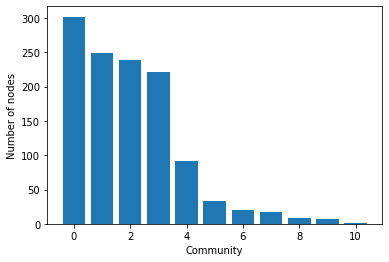

In [150]:
#number of communities detected
print(f'A total of {len(partition_list_marvel.keys())} communities were detected in the Marvel universe')
for comm in partition_list_marvel.keys():
    #sorted according to number of nodes
    print(f"Community {comm} has {len(partition_list_marvel[comm])} nodes")


import matplotlib.pyplot as plt
#plot bar chart of each community and the number of nodes in it sorted according to number of nodes in each community:
sorted_communities = sorted(partition_list_marvel.items(), key=lambda x: len(x[1]), reverse=True)
plt.bar(range(len(sorted_communities)), [len(x[1]) for x in sorted_communities])
plt.xlabel('Community')
plt.ylabel('Number of nodes')
plt.show()

The number of communities detected vary as the algorithm is run , but typically result in a total of 9-11 commmunities. A few large communities, typically with +200 nodes, make up a large proportion of the network. As seen from the commulitative plot below, roughly 90% of all nodes are included in the 5 largest communities. The remaining commmunities held a smaller number of nodes, typically 10-50, and a single community of just 1 node.

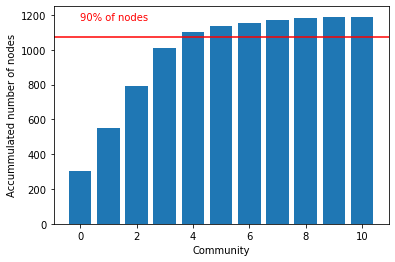

In [151]:
#plot a bar chart with the accumulated number of nodes in each community sorted according to number of nodes in each community:
sorted_communities = sorted(partition_list_marvel.items(), key=lambda x: len(x[1]), reverse=True)
plt.bar(range(len(sorted_communities)), [sum([len(partition_list_marvel[x[0]]) for x in sorted_communities[:i+1]]) for i in range(len(sorted_communities))])
plt.xlabel('Community')
plt.ylabel('Accummulated number of nodes')
#add threshold at 90% of the total number of nodes
plt.axhline(y=0.9*len(G_marvel_un.nodes()), color='r', linestyle='-')
#add text at the threshold
plt.text(0, 0.9*len(G_marvel_un.nodes())+100, '90% of nodes', color='red')
plt.show()

### Task: For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

We start by getting the pickle file of all the heroes

In [152]:
df_superhero = pd.read_pickle('df_superhero_pkl.pkl')
df_superhero.head()

,Unnamed: 0,CharacterName,WikiLink,file,universe,WikiOutLinks,TextLen
0,0,Abin Sur,[Abin Sur],Abin_Sur.json,dc,"[Special:ApiFeatureUsage, DC Comics, John Broo...",5351
1,1,Abra Kadabra (character),[Abra Kadabra (character)],Abra_Kadabra_%28character%29.json,dc,"[Special:ApiFeatureUsage, Oscar Jimenez (comic...",2740
2,2,Abby Holland,[Abby Holland],Abby_Holland.json,dc,"[Special:ApiFeatureUsage, File:SwampThing22.jp...",4446
3,3,Ace the Bat-Hound,[Ace the Bat-Hound],Ace_the_Bat-Hound.json,dc,"[Special:ApiFeatureUsage, Detective Comics, 20...",3294
6,6,Adam Strange,[Adam Strange],Adam_Strange.json,dc,"[Special:ApiFeatureUsage, Alex Ross, DC Comics...",7533


Then we get the pickle file of the Marvel universe only

In [153]:
df_marvel = df_superhero[df_superhero['universe'] == 'marvel']

#### We can then get the 10 largest communities from the sorted community list

In [154]:
sorted_communities = sorted_communities[:10]

Now we iterate over the heroes from each community to find their related files and save the wikitexts as one string for each community.

In [155]:
community_text = {}

#Iterate over each community
for comm_list in sorted_communities:
    #create a item in the dict with key = community number, and value = empty string
    community_text[comm_list[0]] = ''
    #iterate through each node in the community
    for node in comm_list[1]:
        #to identify the associated filename and append wikitext, iterate through the dataframe
        for wikilink, file in zip(df_marvel.WikiLink, df_marvel.file):
        #match the node name with wikilink, and add the text of the node using the file-name association and json loads
            if node == wikilink[0]:
                    with open(f"../wikidata/{file}", "r") as infile:
                        jsonwiki = json.load(infile)
                        #converts the json to a string
                        text_content = str(jsonwiki['query']['pages'])
                        #appends the text of a given character to the community
                        community_text[comm_list[0]] += text_content

#Abin Sur
#marvel_text['Abin Sur']['query']['pages']
community_text.keys()

dict_keys([2, 7, 6, 1, 8, 9, 0, 3, 4, 5])

Then we tokenize the texts to be able to work with the text word for word.

In [156]:
from nltk.tokenize import word_tokenize

# Tokenize the community text
for comm in community_text.keys():
    community_text[comm] = word_tokenize(community_text[comm])

#### We can now calculate the TF of each word in each community.

In [163]:
import nltk

stopwords = nltk.corpus.stopwords.words('english')

freqDist = {}

# Calculate the frequency distribution of the words in each community
for comm in community_text.keys():
    freqDist[comm] = nltk.FreqDist(word.lower() for word in community_text[comm] if word.isalpha() and word.lower() not in stopwords)

Then we can print the top 5 words of each of the 10 largest communities.

In [164]:
# Get the top 5 words in each community
for comm in sorted(freqDist.keys()):
    print(f'Community {comm} top 5 words: {freqDist[comm].most_common(5)}')

Community 0 top 5 words: [('comics', 467), ('ref', 443), ('flight', 346), ('marvel', 344), ('hero', 255)]
Community 1 top 5 words: [('ref', 9922), ('marvel', 8993), ('comics', 8075), ('cite', 3268), ('category', 2646)]
Community 2 top 5 words: [('ref', 11986), ('marvel', 11730), ('comics', 10141), ('cite', 4322), ('category', 3146)]
Community 3 top 5 words: [('comics', 570), ('ref', 388), ('marvel', 355), ('kid', 222), ('category', 178)]
Community 4 top 5 words: [('ref', 509), ('marvel', 417), ('comics', 324), ('cite', 271), ('kung', 168)]
Community 5 top 5 words: [('marvel', 132), ('comics', 112), ('ref', 95), ('doom', 85), ('category', 68)]
Community 6 top 5 words: [('ref', 9080), ('marvel', 8391), ('comics', 7683), ('man', 3175), ('cite', 3077)]
Community 7 top 5 words: [('comics', 10364), ('ref', 9437), ('marvel', 7221), ('category', 2815), ('mutant', 2334)]
Community 8 top 5 words: [('ref', 4103), ('marvel', 3227), ('comics', 2915), ('cite', 1112), ('category', 958)]
Community 9 t

From the list of the most frequent words above, it can be seen that most of the words are stopwords. We could remove these but as we are also going to calculate IDF, then it becomes less important as this will make the stopwords less important.

#### We can then calculate IDF for every word in every list

In [165]:
# Calculate the inverse document frequency (IDF) by taking the logarithm (base 2) of the inverse frequency of the word in each community
idf = {}

for comm in freqDist.keys():
    idf[comm] = {}
    for word in freqDist[comm].keys():
        idf[comm][word] = np.log2(len(freqDist[comm].keys()) / freqDist[comm][word])

In [166]:
# Get the top 5 words in each community according to IDF
for comm in sorted(idf.keys()):
    print(f'Community {comm} top 5 words according to IDF: {sorted(idf[comm].items(), key=lambda x: x[1], reverse=True)[:5]}')

Community 0 top 5 words according to IDF: [('marc', 12.17367713630342), ('silvestri', 12.17367713630342), ('renowned', 12.17367713630342), ('physicist', 12.17367713630342), ('packers', 12.17367713630342)]
Community 1 top 5 words according to IDF: [('consensus', 14.376125389276174), ('crouched', 14.376125389276174), ('webhead', 14.376125389276174), ('relegated', 14.376125389276174), ('inadequacy', 14.376125389276174)]
Community 2 top 5 words according to IDF: [('rabum', 14.514159254406481), ('hassenstadt', 14.514159254406481), ('maleficium', 14.514159254406481), ('technopathy', 14.514159254406481), ('culp', 14.514159254406481)]
Community 3 top 5 words according to IDF: [('disease', 11.919235786028347), ('sept', 11.919235786028347), ('funeral', 11.919235786028347), ('demoted', 11.919235786028347), ('secondary', 11.919235786028347)]
Community 4 top 5 words according to IDF: [('converted', 12.031356596255709), ('cheung', 12.031356596255709), ('laura', 12.031356596255709), ('alliances', 12.

To calculate the IDF we used the base 2 logarithm which is the most commonly used for TF-IDF. The score becomes higher, the smaller the base is which can affect the result score.

#### We can now calculate TF-IDF for each word in each community

In [167]:
# The TF-IDF is the product of the term frequency and the inverse document frequency
tf_idf = {}

for comm in freqDist.keys():
    tf_idf[comm] = {}
    for word in freqDist[comm].keys():
        tf_idf[comm][word] = freqDist[comm][word] * idf[comm][word]

In [168]:
# List the top 10 words in each community according to TF-IDF
for comm in sorted(tf_idf.keys()):
    print(f'Community {comm} top 10 words according to TF-IDF: {sorted(tf_idf[comm].items(), key=lambda x: x[1], reverse=True)[:10]}')

Community 0 top 10 words according to TF-IDF: [('comics', 1544.088051209285), ('ref', 1498.453811752542), ('flight', 1293.7109223986765), ('marvel', 1289.1098592708547), ('hero', 1065.7275433583634), ('alpha', 1046.431244827303), ('category', 1004.1114010542497), ('cite', 706.2151767101835), ('big', 654.7460488132414), ('characters', 620.4875527562418)]
Community 1 top 10 words according to TF-IDF: [('comics', 11279.796671820763), ('marvel', 11165.156952754902), ('ref', 10911.32408233905), ('cite', 8829.917439854444), ('category', 7955.27320177138), ('character', 7817.133289568787), ('amazing', 7381.792358540848), ('peter', 7371.188752487636), ('new', 7280.138353929604), ('characters', 6701.311837271268)]
Community 2 top 10 words according to TF-IDF: [('comics', 12232.550339355139), ('marvel', 11685.940495284849), ('ref', 11567.647797690897), ('cite', 10531.313229198016), ('category', 9107.217916625037), ('character', 8212.202483803145), ('vol', 7695.600189979403), ('avengers', 7676.52

### Task: Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

In [170]:
# Combine the TF-IDF values of all communities into a single string
community_strings = {}

for comm in tf_idf.keys():
    community_strings[comm] = ' '.join([word for word in tf_idf[comm].keys()])

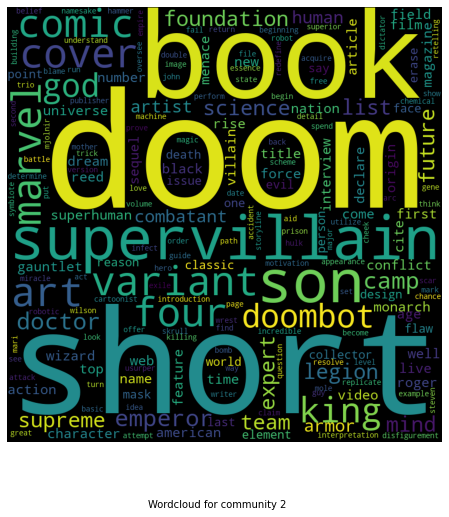

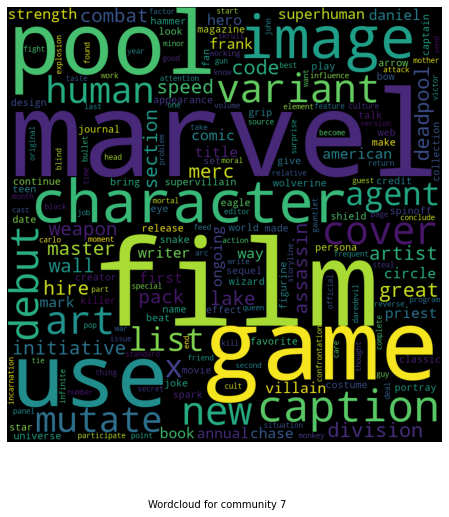

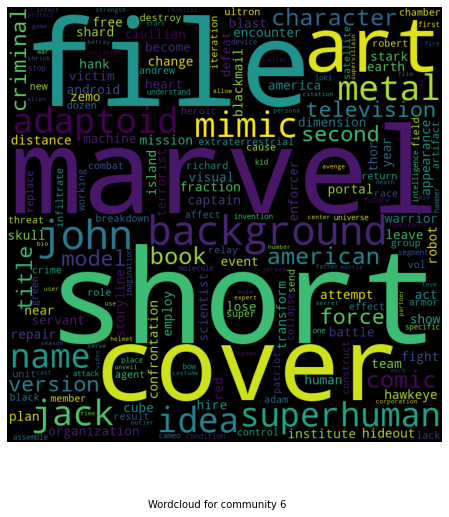

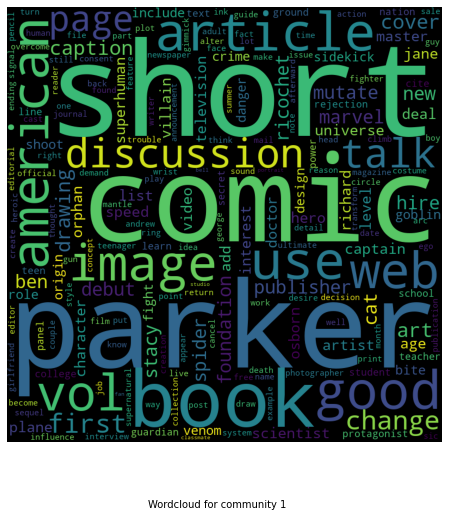

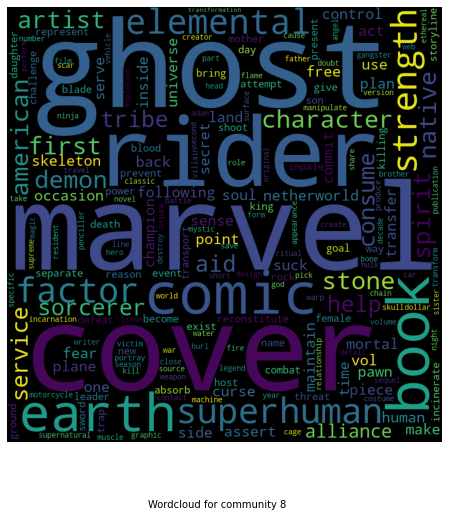

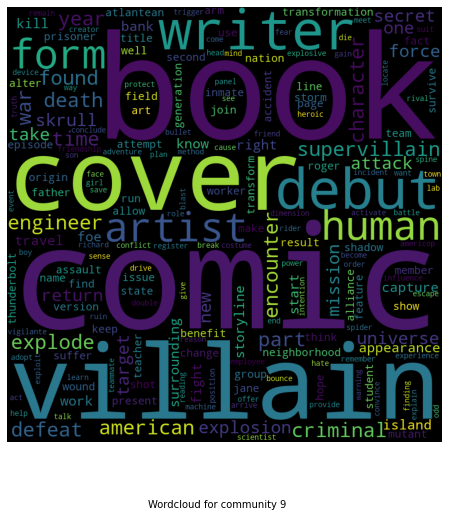

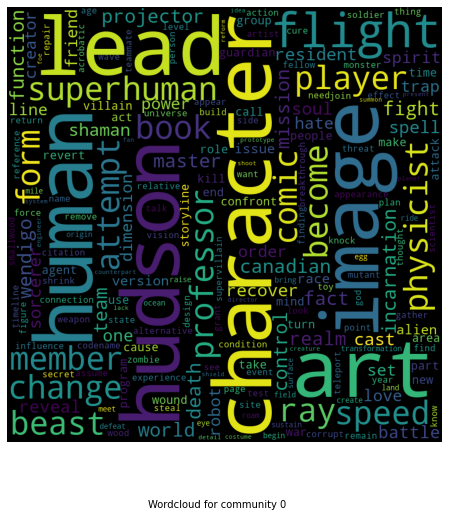

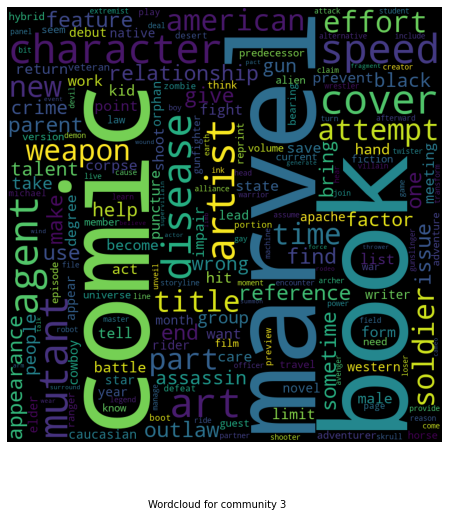

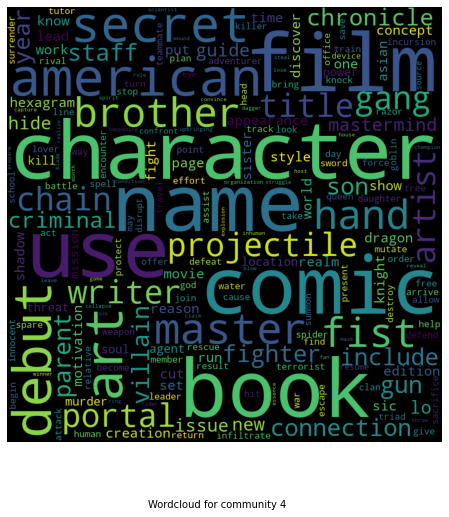

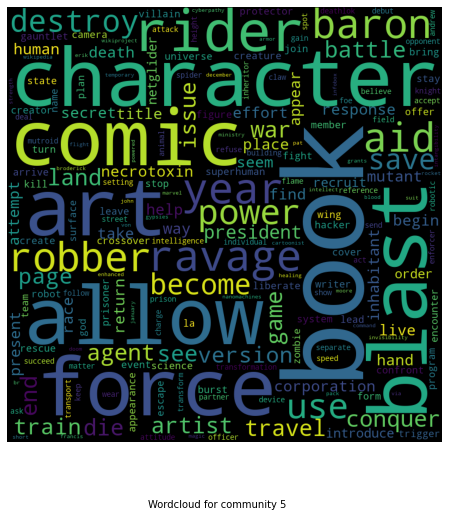

In [183]:
# Create a word cloud for each community
from wordcloud import WordCloud, STOPWORDS

for comm in community_strings.keys():
    wordcloud = WordCloud(
                width = 800, 
                height = 800,
                background_color ='black',
                stopwords = STOPWORDS
                ).generate(community_strings[comm])
    fig = plt.figure(figsize = (8, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    fig.text(.5, .01, f'Wordcloud for community {comm}', ha='center')
    plt.show()